<a href="https://colab.research.google.com/github/david8712403/solar-energy-predict/blob/main/solar_energy_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIoT 期末報告
## 說明
- dataset\solar_data_202003_202007.csv 為 **新竹市北區海濱路240號** 新竹市環保局掩埋場復育地太陽能案場在 **3月至7月** 其中一個inverter(逆變器)的太陽能發電資料

將資料集(dataset)內的 solar_data_202003_202007.csv 的太陽能案場發電資料做為訓練資料集訓練你的預測模型，用機器學習及深度學習皆可，預測 2020年一月、二月、八月、九月、十月的 **"下一個小時"的發電度數** 。

# 作業
[作業網址: http://aiot.codingmaster.cc:8000](http://aiot.codingmaster.cc:8000)
### 登入帳號為
- 大同大學： ttu + 學號

In [177]:
# 抽卡!!!
!/opt/bin/nvidia-smi

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [178]:
# 下載資料集
!gdown --id '1WbbqzP3veoI155D6rPco4sbVVAN8kEJp' --output training_data.csv
!gdown --id '1kjRjzk9mt2JJAiEraUNGo14526ftO537' --output test_data.csv

Downloading...
From: https://drive.google.com/uc?id=1WbbqzP3veoI155D6rPco4sbVVAN8kEJp
To: /content/training_data.csv
3.65MB [00:00, 17.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kjRjzk9mt2JJAiEraUNGo14526ftO537
To: /content/test_data.csv
100% 44.9k/44.9k [00:00<00:00, 1.44MB/s]


In [179]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

import pandas as pd

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

!pip install matplotlib mlxtend
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
%matplotlib inline
  
def sameSeed(myseed = 0): # set a random seed for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(myseed)
    torch.manual_seed(myseed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(myseed)

In [180]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    print(loss_record['train'])
    print(loss_record['validate'])
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['validate'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['validate'], c='tab:cyan', label='validate')
    # plt.ylim(0.0, max(loss_record['validate']))
    plt.ylim(0.0, 20)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [181]:
import datetime
"""
取得氣象資料
"""
def get_sun_shine_df(start_date, end_date):

  rtn_df = pd.DataFrame()
  # 設定時間區間
  l = pd.date_range(start=start_date,end=end_date)
  for d in l:
    date_str = d.date().strftime("%Y-%m-%d")
    print(f'\r取得{date_str}的天氣資料', end='')

    wether_df = pd.read_html(
        'https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?'+
        'command=viewMain&station=467571&stname=%25E6%2596%25B0%25E7%25AB%25B9&datepicker='+
        date_str,
        encoding='utf-8'
    )
    wether_df = wether_df[1]

    temp_sun_df = pd.DataFrame(columns=['GloblRad', 'SunShine', 'Cloud', 'MONTH', 'DAY', 'HOUR'])
    temp_sun_df['GloblRad'] = wether_df['SunShine']['全天空日射量(MJ/㎡)']['GloblRad']
    temp_sun_df['SunShine'] = wether_df['SunShine']['日照時數(hr)']['SunShine']
    temp_sun_df['Cloud'] = wether_df['Cloud']['總雲量(0~10)']['Cloud Amount']
    temp_sun_df = temp_sun_df.replace({'SunShine': '...'}, 0)
    temp_sun_df = temp_sun_df.replace({'Cloud': '...'}, 0)
    temp_sun_df['MONTH'] = d.month
    temp_sun_df['DAY'] = d.day
    temp_sun_df['HOUR'] = wether_df['Unnamed: 0_level_0']['觀測時間(hour)']['ObsTime'] - 1

    rtn_df = rtn_df.append(temp_sun_df, ignore_index=True)

  print(f"\n{start_date}~{end_date}天氣資料")
  print(rtn_df)
  return rtn_df

In [182]:
# 取得test_data的氣象資料（1~2及8~10月）
# 取得1~2月日照資料
test_sun_df = get_sun_shine_df("2020-01-01", "2020-02-29")
# 取得8~10月日照資料並與1~2月合併
test_sun_df_2 = get_sun_shine_df("2020-08-01", "2020-10-31")
test_sun_df = test_sun_df.append(test_sun_df_2, ignore_index=True)

取得2020-02-29的天氣資料
2020-01-01~2020-02-29天氣資料
      GloblRad SunShine Cloud  MONTH  DAY  HOUR
0          0.0        0     0      1    1     0
1          0.0        0     0      1    1     1
2          0.0        0     0      1    1     2
3          0.0        0     0      1    1     3
4          0.0        0   9.0      1    1     4
...        ...      ...   ...    ...  ...   ...
1435       0.0        0   2.0      2   29    19
1436       0.0        0   2.0      2   29    20
1437       0.0        0     0      2   29    21
1438       0.0        0     0      2   29    22
1439       0.0        0     0      2   29    23

[1440 rows x 6 columns]
取得2020-10-31的天氣資料
2020-08-01~2020-10-31天氣資料
      GloblRad SunShine Cloud  MONTH  DAY  HOUR
0          0.0        0     0      8    1     0
1          0.0        0     0      8    1     1
2          0.0        0     0      8    1     2
3          0.0        0     0      8    1     3
4          0.0        0   3.0      8    1     4
...        ...      ...

In [183]:
# 下載test_data，並與氣象資料合併
!gdown --id '1kjRjzk9mt2JJAiEraUNGo14526ftO537' --output test_data.csv
test_df = pd.read_csv('/content/test_data.csv')
test_df = pd.merge(test_df,test_sun_df)
test_df.to_csv('/content/test_data.csv', index=False)
test_df

Downloading...
From: https://drive.google.com/uc?id=1kjRjzk9mt2JJAiEraUNGo14526ftO537
To: /content/test_data.csv
100% 44.9k/44.9k [00:00<00:00, 1.39MB/s]


,NO,MONTH,DAY,HOUR,OPTPWR,ACV1,ACV2,ACCL1,ACCL2,ACF1,IIT,IHT,DCVL1,DCVL2,IPA,IPB,TOTALKWH,GloblRad,SunShine,Cloud
0,1,1,1,9,5.02,229,226,7.5,7.2,60.2,34,37,775,772,2.48,2.56,37689,0.60,0.0,0
1,2,1,1,12,16.66,231,227,24.6,23.5,60.1,32,33,783,776,8.30,8.38,37711,0.60,0.0,0
2,3,1,1,15,6.97,229,225,10.6,10.1,60.1,35,36,858,780,3.45,3.53,37730,0.60,0.1,0
3,4,1,2,6,0.88,232,227,2.3,2.1,60.1,26,20,765,759,0.41,0.49,37732,0.00,0.0,0
4,5,1,2,9,15.64,231,226,23.0,22.0,60.1,33,36,779,772,7.79,7.87,37755,1.57,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,639,10,30,15,12.84,230,226,19.2,18.2,60.1,38,38,781,776,6.39,6.47,73561,0.96,1.0,0
639,640,10,31,6,2.19,231,228,3.9,3.3,60.1,35,29,746,768,1.07,1.15,73566,0.16,0.6,0
640,641,10,31,9,17.80,234,231,26.4,25.7,60.1,39,42,767,749,8.87,8.95,73597,2.17,1.0,0
641,642,10,31,12,21.62,234,231,31.7,30.8,60.5,43,49,734,713,10.78,10.86,73653,2.40,1.0,0


In [184]:
train_sun_df = get_sun_shine_df("2020-03-01", "2020-07-31")

取得2020-07-31的天氣資料
2020-03-01~2020-07-31天氣資料
      GloblRad SunShine Cloud  MONTH  DAY  HOUR
0          0.0        0     0      3    1     0
1          0.0        0     0      3    1     1
2          0.0        0     0      3    1     2
3          0.0        0     0      3    1     3
4          0.0        0   2.0      3    1     4
...        ...      ...   ...    ...  ...   ...
3667       0.0        0   9.0      7   31    19
3668       0.0        0   8.0      7   31    20
3669       0.0        0     0      7   31    21
3670       0.0        0     0      7   31    22
3671       0.0        0     0      7   31    23

[3672 rows x 6 columns]


In [185]:
df = pd.read_csv('/content/training_data.csv')
df.insert(4, 'timedelta', 0)
df.insert(5, 'kwh', 0)
df['Local_Time'] = df['Local_Time'].str.replace('.000', '')

df['Local_Time'] = pd.to_datetime(df['Local_Time'], format='%Y-%m-%d %H:%M:%S')
df['timedelta'] = (df['Local_Time'].values.astype('int64')  // 10**9) \
                    - (df['Local_Time'].shift(1).values.astype('int64') // 10**9)
df['timedelta'][0] = 0

df['kwh'] = df['OPTPWR'].rolling(2).sum() / 2
df['kwh'] = (df['kwh'] * df['timedelta'] / 3600).round(3)

df2 = pd.DataFrame()
df2 = df[['Local_Time','OPTPWR','timedelta','kwh','ACV1','ACV2','ACCL1','ACCL2','ACF1','IIT','IHT','DCVL1','DCVL2','IPA','IPB','TOTALKWH']]

df2 = df2.groupby(pd.Grouper(key='Local_Time', freq='60Min')).max().reset_index()

df3 = df.groupby(pd.Grouper(key='Local_Time', freq='60Min')).sum().reset_index()
df2['kwh'] = df3['kwh']

df2 = df2.drop(df2[df2['kwh'] <= 0].index)
df2 = df2.drop(columns='timedelta')

df2.insert(1, 'HOUR', 0)
df2.insert(1, 'DAY', 0)
df2.insert(1, 'MONTH', 0)
df2['MONTH'] = pd.DatetimeIndex(df2['Local_Time']).month
df2['DAY'] = pd.DatetimeIndex(df2['Local_Time']).day
df2['HOUR'] = pd.DatetimeIndex(df2['Local_Time']).hour

df2 = df2.drop(columns='Local_Time')

# TODO[Boss]: 加入氣象資料 (https://e-service.cwb.gov.tw/HistoryDataQuery/)
# 合併氣象資料
df2 = pd.merge(df2,train_sun_df)

df2.insert(len(df2.columns)-1, 'kwh', df2.pop('kwh'))

# TODO[Medium]: 我們要預測的是 "下一個" 小時的發電量
# kwh欄位向上位移一小時
df2['kwh'] = df2['kwh'].shift(-1)

# TODO[Medium]: 資料過濾，檢查資料是否正常
df2 = df2[df2['kwh'] < 30]
df2 = df2[df2['ACV1'] > 5]
df2 = df2.drop(df2[(df2['HOUR'] == 18) & (df2['kwh'] >= 10)].index)

df2.to_csv('/content/training_data_processed.csv', header=False)

df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MONTH,DAY,HOUR,OPTPWR,ACV1,ACV2,ACCL1,ACCL2,ACF1,IIT,IHT,DCVL1,DCVL2,IPA,IPB,TOTALKWH,GloblRad,SunShine,Cloud,kwh
0,3,1,6,1.54,231.0,228.0,3.0,2.7,60.1,31.0,25.0,778.0,771.0,0.78,0.78,43355.0,0.00,0.0,0,3.100
1,3,1,7,4.85,231.0,228.0,7.5,6.8,60.2,37.0,38.0,770.0,780.0,2.42,2.42,43358.0,0.41,0.0,10.0,7.349
2,3,1,8,9.62,233.0,228.0,14.3,13.6,60.1,39.0,42.0,772.0,771.0,4.89,4.89,43365.0,0.55,0.0,10.0,7.851
3,3,1,9,15.28,232.0,228.0,22.3,21.6,60.1,41.0,36.0,780.0,770.0,6.77,8.10,43373.0,0.50,0.0,0,3.695
4,3,1,10,7.55,231.0,227.0,11.4,10.6,60.1,41.0,46.0,778.0,760.0,3.76,3.77,43376.0,0.76,0.0,10.0,7.912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1752,7,31,13,21.90,229.0,225.0,33.0,32.1,60.4,57.0,62.0,695.0,672.0,11.18,11.13,62055.0,3.01,1.0,4.0,19.139
1753,7,31,14,20.80,230.0,228.0,30.4,29.7,60.3,55.0,59.0,710.0,694.0,10.57,10.48,62074.0,2.63,1.0,0,14.100
1754,7,31,15,18.20,231.0,228.0,27.0,25.9,60.1,52.0,53.0,724.0,719.0,9.19,9.16,62088.0,1.74,1.0,0,8.439
1755,7,31,16,13.75,230.0,228.0,20.3,19.7,60.1,51.0,48.0,705.0,720.0,6.79,7.01,62097.0,1.03,0.8,4.0,4.947


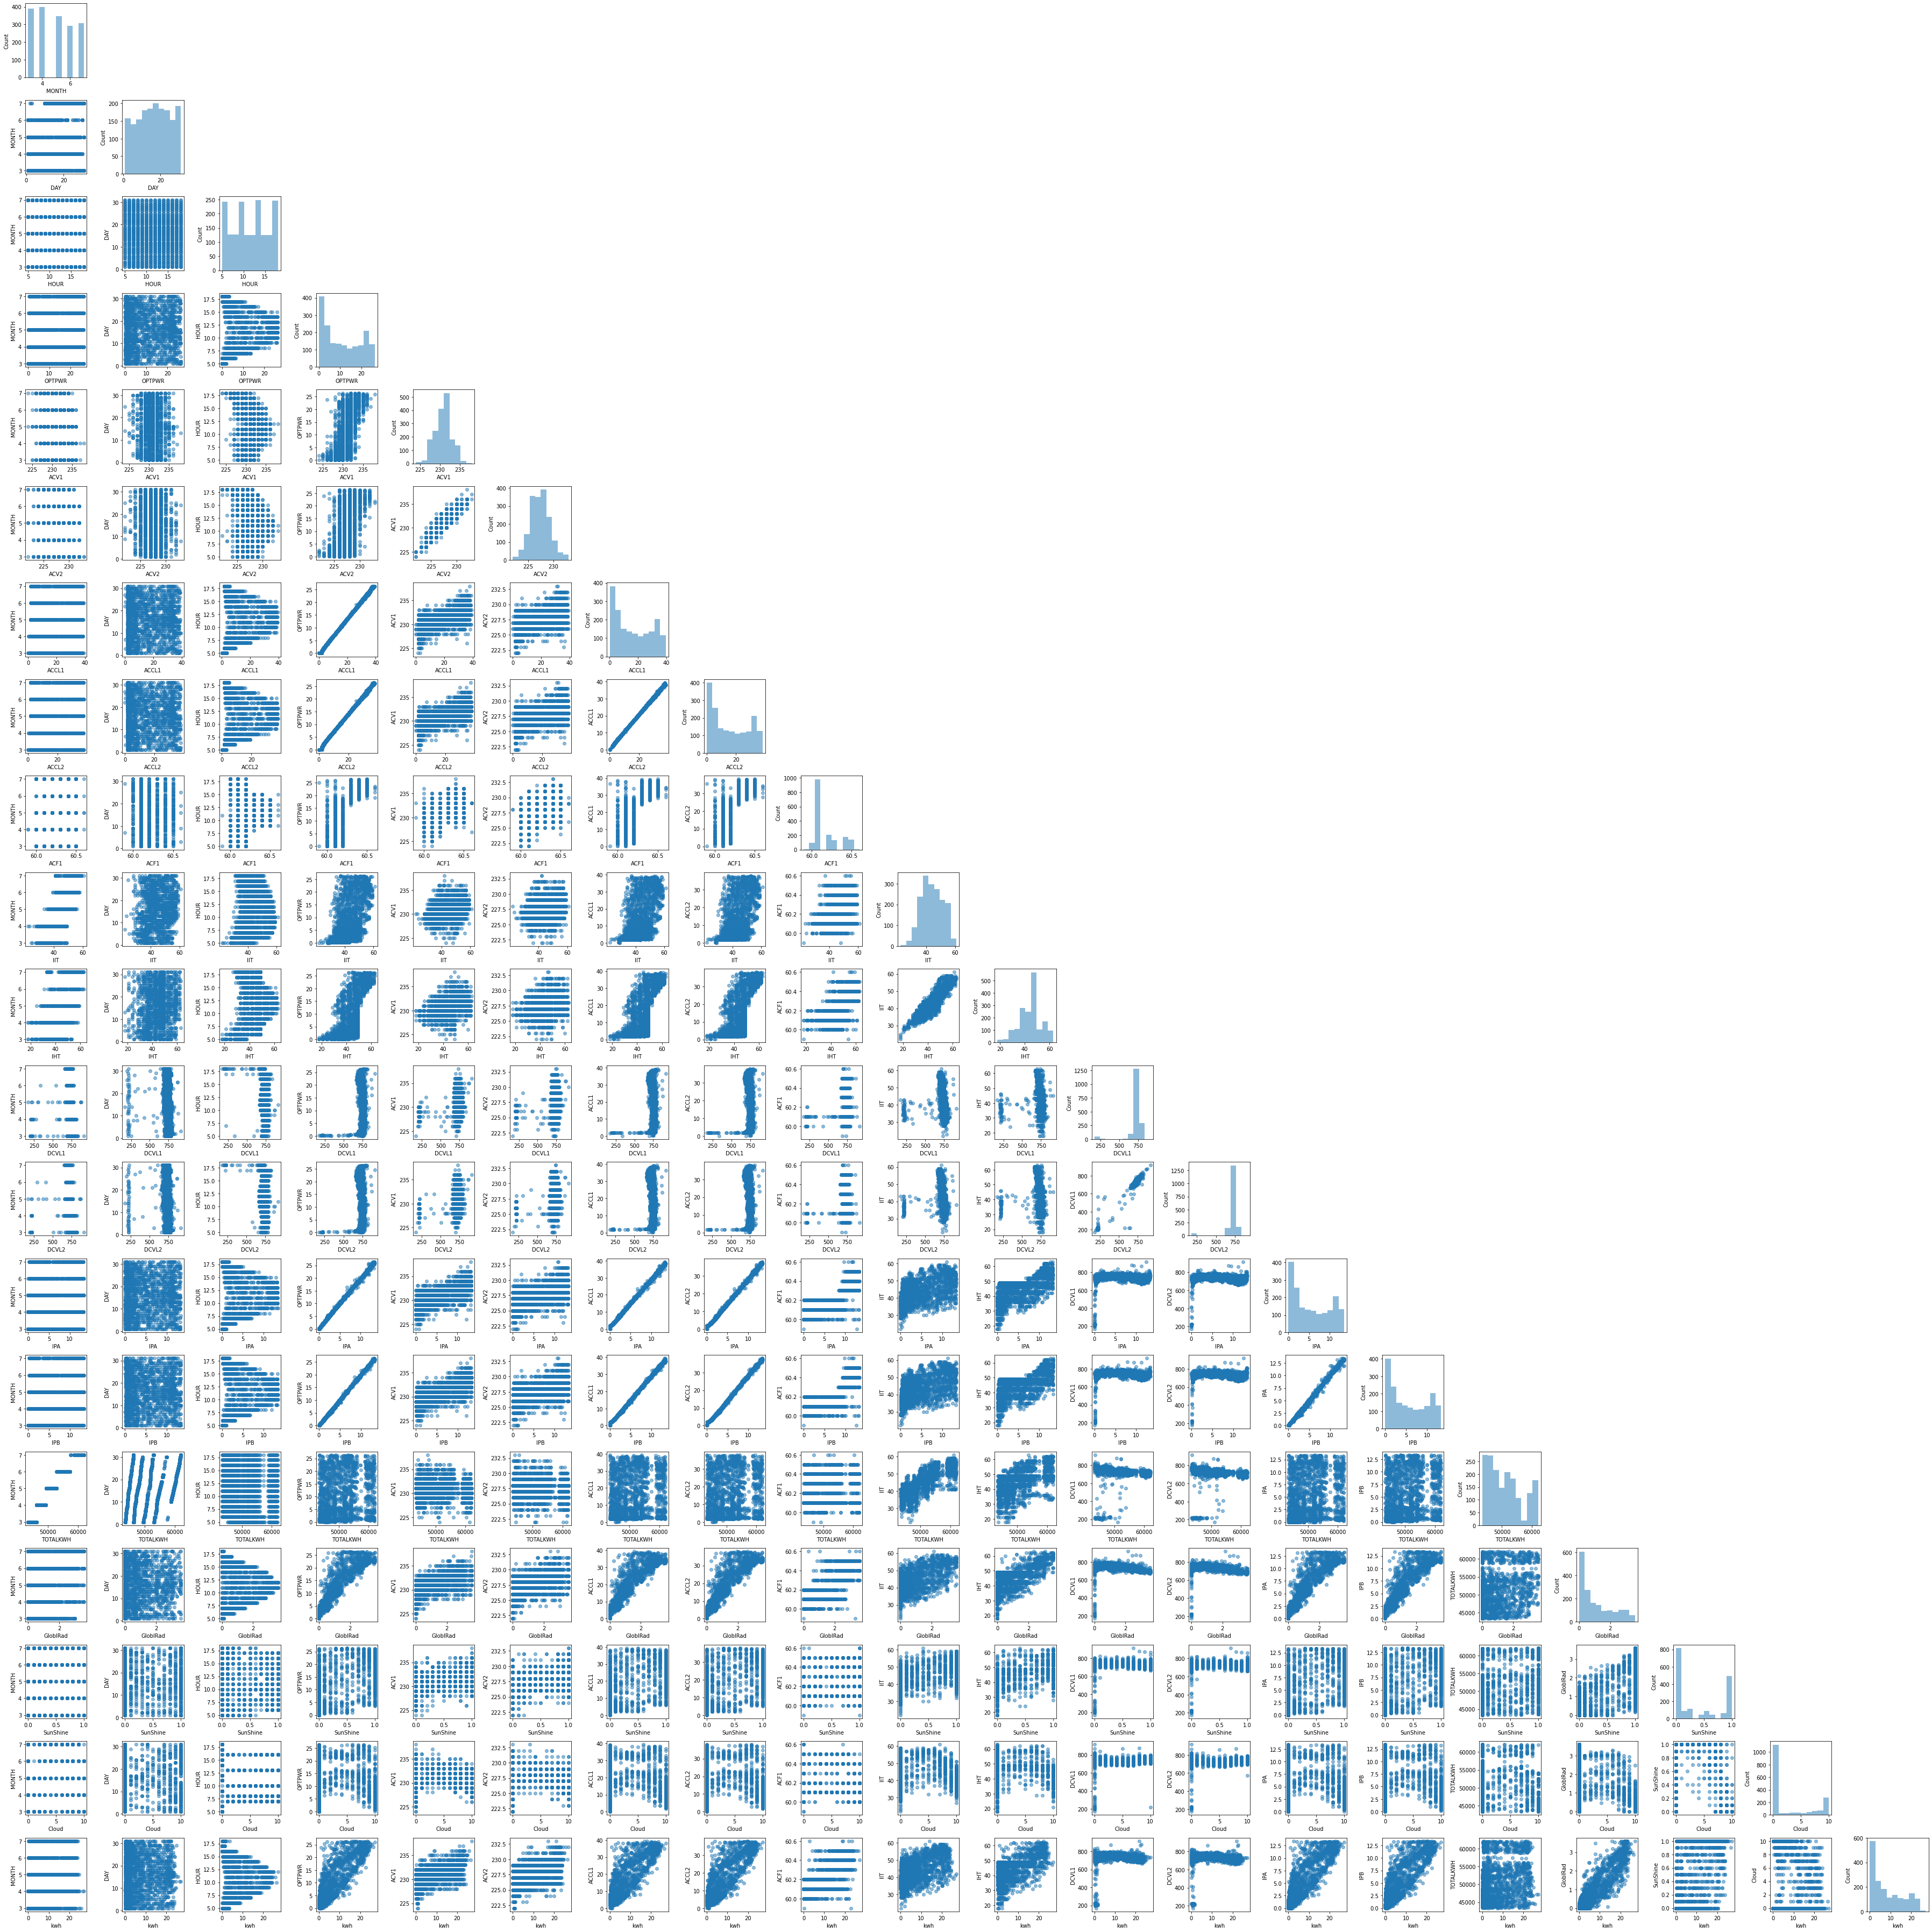

In [186]:
# cols = ['MONTH','DAY','HOUR','OPTPWR','ACV1','ACV2','ACCL1','ACCL2','ACF1','IIT','IHT','DCVL1','DCVL2','IPA','IPB','TOTALKWH','GloblRad','SunShine','Cloud','kwh']
# scatterplotmatrix(df2[cols].values.astype(float), figsize=(50,50), names=cols, alpha=0.5)
# plt.tight_layout()
# plt.show()

In [226]:
from itertools import chain

class SolarDataset(Dataset):
    def __init__(self, path, mode='train', shuffle=False):
        self.mode = mode
        
        with open(path, 'r') as fp:
            lines = fp.readlines()
            if mode == 'test':
                lines.pop(0)
        if shuffle:
            import random
            random.seed(0)
            random.shuffle(lines)
        for line in lines:
            temp = line.split(',')
            break

        len_features = 11 # 資料特徵數量
        data = np.empty((0, len_features), float)
        target = np.empty((0, 1), float)
        target = np.array([])
        #   1     2   3     4       5     6     7     8     9     10  11  12    13    14  15  16        17        18        19    20
        # 	MONTH	DAY	HOUR	OPTPWR	ACV1	ACV2	ACCL1	ACCL2	ACF1	IIT	IHT	DCVL1	DCVL2	IPA	IPB	TOTALKWH	GloblRad	SunShine  Cloud	kwh
        for line in lines:
            temp_s = line.replace('\n', '').split(',')
            temp = [t if t != '' else 0 for t in temp_s ]
            # data = np.append(data, np.array([temp[:len_features]]).astype(np.float), axis=0)
            # TODO[Medium]: 選取重要的特徵資料 
            data = np.append(data, np.array([list(chain(
                temp[3:4],    # HOUR 
                temp[4:5],    # OPTPWR
                temp[5:7],    # ACV1	ACV2
                temp[7:9],    # ACCL1	ACCL2
                temp[10:12],  # IIT	IHT
                temp[14:16],  # IPA	IPB
                temp[17:18],  # GloblRad
                ))]).astype(np.float), axis=0)
            target = np.append(target, np.array([temp[-1]]).astype(np.float), axis=0)
        
        if mode == 'train':
            indices = [i for i in range(len(data)) if i % 10 != 4]
        elif mode == 'validate':
            indices = [i for i in range(len(data)) if i % 10 == 4]
        else:
            indices = [i for i in range(len(data))]

        self.data = torch.FloatTensor(data[indices])
        self.target = torch.FloatTensor(target[indices])
        self.dim = self.data.shape[1]

        self.data[:, 0:] = \
            (self.data[:, 0:] - self.data[:, 0:].mean(dim=0, keepdim=True)) \
            / self.data[:, 0:].std(dim=0, keepdim=True)

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'validate']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]
    
    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [227]:
SolarDataset('/content/training_data_processed.csv')

In [228]:
def prep_dataloader(path, mode, batch_size, n_jobs=0):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = SolarDataset(path, mode=mode)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [265]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO[Strong, Boss]: 要如何修改模型增加預測的準確度?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        return self.criterion(pred, target)

In [266]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''
    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'validate': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print(f'{datetime.datetime.now()}: ',end='')
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['validate'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [267]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [268]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/                 
 # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 5000,                # maximum number of epochs
    'batch_size': 128,               # mini-batch size for dataloader
    # TODO[Strong]: 嘗試其他 optimizer ，參考 https://pytorch.org/docs/stable/optim.html
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.0025,                 # learning rate of SGD
        # 'lr_decay': 0.001,
        # 'weight_decay': 0.05,
        # 'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

In [269]:
tr_set = prep_dataloader('/content/training_data_processed.csv', 'train', config['batch_size'])
dv_set = prep_dataloader('/content/training_data_processed.csv', 'validate', config['batch_size'])

In [270]:
sameSeed(1)
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

2021-06-10 07:21:40.350837: Saving model (epoch =    1, loss = 122.9744)
2021-06-10 07:21:40.375208: Saving model (epoch =    2, loss = 97.4658)
2021-06-10 07:21:40.398085: Saving model (epoch =    3, loss = 39.3834)
2021-06-10 07:21:40.421047: Saving model (epoch =    4, loss = 24.5063)
2021-06-10 07:21:40.443591: Saving model (epoch =    5, loss = 17.2838)
2021-06-10 07:21:40.466784: Saving model (epoch =    6, loss = 14.2574)
2021-06-10 07:21:40.490581: Saving model (epoch =    7, loss = 11.8525)
2021-06-10 07:21:40.514136: Saving model (epoch =    8, loss = 10.2979)
2021-06-10 07:21:40.539352: Saving model (epoch =    9, loss = 9.3483)
2021-06-10 07:21:40.566965: Saving model (epoch =   10, loss = 8.8153)
2021-06-10 07:21:40.590909: Saving model (epoch =   11, loss = 8.6113)
2021-06-10 07:21:40.615662: Saving model (epoch =   12, loss = 8.3822)
2021-06-10 07:21:40.639190: Saving model (epoch =   13, loss = 8.2554)
2021-06-10 07:21:40.669136: Saving model (epoch =   14, loss = 7.979

[127.74368286132812, 107.08892822265625, 143.3548126220703, 132.66468811035156, 117.00680541992188, 131.307861328125, 115.74728393554688, 117.92147064208984, 121.31491088867188, 110.28095245361328, 138.65184020996094, 127.93289947509766, 43.442405700683594, 109.55709075927734, 140.54443359375, 123.51520538330078, 108.53199768066406, 98.08378601074219, 132.8167266845703, 102.52799987792969, 116.64390563964844, 101.47539520263672, 90.42894744873047, 101.67149353027344, 97.99032592773438, 56.41741180419922, 93.89017486572266, 91.4662094116211, 65.41675567626953, 73.60971069335938, 77.11068725585938, 74.18924713134766, 83.3135757446289, 80.67374420166016, 63.70079803466797, 48.56734848022461, 56.90296173095703, 41.17613220214844, 33.394161224365234, 37.43048095703125, 27.200824737548828, 23.707332611083984, 21.030866622924805, 22.25481605529785, 14.550006866455078, 15.488113403320312, 19.852697372436523, 16.243824005126953, 15.148131370544434, 21.263389587402344, 25.23598861694336, 39.0470

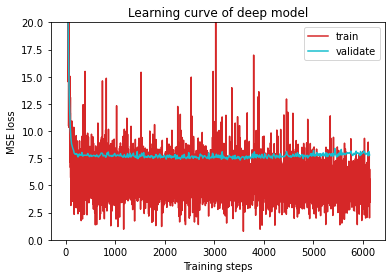

In [271]:
plot_learning_curve(model_loss_record, title='deep model')

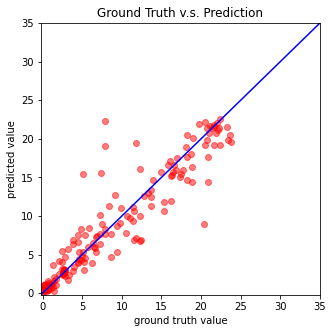

In [272]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [273]:
from sklearn.metrics import mean_squared_error, r2_score

def test(tt_set, model, device, mode='validate'):
    model.eval()                                # set model to evalutation mode
    preds = []
    if mode != 'test':
        targets = np.array([])
        for x, y in tt_set:                            # iterate through the dataloader
            targets = np.concatenate((targets, y.cpu().numpy()))
            x = x.to(device)                        # move data to device (cpu/cuda)
            with torch.no_grad():                   # disable gradient calculation
                pred = model(x)                     # forward pass (compute output)
                preds.append(pred.detach().cpu())   # collect prediction
        preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
        mse = mean_squared_error(targets, preds)
        r2 = r2_score(targets, preds)
        print('validate mse: %.3f, r2: %.3f' % (mse, r2))
    else:
        for x in tt_set:                            # iterate through the dataloader
            x = x.to(device)                        # move data to device (cpu/cuda)
            with torch.no_grad():                   # disable gradient calculation
                pred = model(x)                     # forward pass (compute output)
                preds.append(pred.detach().cpu())   # collect prediction
        preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [274]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'predict_kwh'])
        for i, p in enumerate(preds):
            writer.writerow([i+1, p])

preds = test(dv_set, model, device)  
save_pred(preds, 'pred.csv')   

validate mse: 7.335, r2: 0.871
Saving results to pred.csv


In [275]:
test_set = prep_dataloader('/content/test_data.csv', 'test', config['batch_size'])

In [276]:
preds = test(test_set, model, device, mode='test')  # 產生預測資料
save_pred(preds, 'pred.csv') 

Saving results to pred.csv


# 作業繳交
- 將作業 .csv檔案 上傳即可看到分數

## 期末分數
### 實作(70%)
- 取最低的 MSE
- Simple Baseline: 60~69分
- Medium Baseline: 70~79分
- Strong Baseline: 80~89分
- Boss Baseline: 90~100分

### 報告(30%)
- 每組 1-3 人
- 每組報告 5 - 10 分鐘
- 報告 Outlines
    - 組員及分工
    - 資料處理方式
    - 使用的訓練模型 (成功做出兩個或以上模型會加分，有機器學習與深度學習的比較更佳)
    - 最高分數 與 分析模型優點 (or 多個模型間的互相比較)
    - 過程中遇到的困難及如何解決 or 心得 or 這學期上課的收穫
    - 課程建議 (如果沒有建議可以不用)

### 報告順序
將在 5/19(三) 上課時抽出

# 注意事項及規則
- 每組一天只能上傳五次，請勿用任何方式上傳超過五次
- 伺服器又貴又脆弱，請不要攻擊它QQ
- 請不要把你的預測資料給其他同學上傳
- 請不要分享你的 CODE 給其他同學或是其他生物
- 請勿使用你用其他管道拿到其它天的發電資料，或是在網路上找到的其他發電資料
- 請勿使用任何別人已經訓練過的 pre-train model
- 伺服器會記錄你每次上傳的答案，所以很容易抓到你上傳其他同學的資料
- 違反以上任何規則，以作弊論，期末作業直接0分，不得異議